In [1]:
# 인공신경망관련 패키지
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

# 회귀분석 관련 패키지
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor


# 시각화 패키지
from matplotlib import pyplot as plt
import seaborn as sb

# 데이터 처리를 위한 패키지
import pandas as pd
import numpy as np
import math

# 다중공선성(multicollinearity) 처리를 위한VIF 확인 패키지
from statsmodels.stats.outliers_influence import variance_inflation_factor

# DeprecationWarning경고 무시
# 향후 안쓰일 함수들을 이용해서 만들어져 있기 때문에 필요하다 없으면, 사방이 붉어진다.
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

Using TensorFlow backend.
C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
#########################################################################
# MAD 기반 예제코드
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh 

# 출처: https://pythonanalysis.tistory.com/7 [Python 데이터 분석]
#########################################################################

# 소셜 데이터 처리를 위한 함수
# 1. 모든 소셜 데이터 column들의 첫번째는 : 날짜다.
# 2. 각 소셜데이터는 social_키워드.블로그/트위터/뉴스/총합 으로 되어 있다.
def changeColNames(d,before, after) : 
    # 컬럼이름 시리즈로 만들어 반환
    # 통합하기 쉽게, 모든 데이터들의 날짜컬럼 이름을 date로 통일
    new_col_names = ['date']
    new_col_names.extend(list(d.columns)[1:])
    d.columns = new_col_names
    return pd.Series(d.columns).apply(lambda x : x.replace(before,after))

#########################################################################
# modeling 함수로 만들어 처리하기
def linReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item, cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
  
    print('LinearRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(model.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(model.score(X_test, y_test)))

    
def ridgeReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    ridge = Ridge(alpha=0.1, normalize=True, random_state=0, tol=0.001).fit(X_train, y_train)
    
    print('RidgeRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(ridge.score(X_train, y_train)))
    print('검증세트점수 : {:.2f}'.format(ridge.score(X_test, y_test)))


def lassoReg(df, item, cols_using):
    cols = cols_using
    X = df.loc[df['category']==item,cols]
    y = df.loc[df['category']==item,'qty']

    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

    lasso = Lasso(alpha=0.1, max_iter=1000).fit(X=X_train, y=y_train)
  
    print('LassoRegression을 이용한 %s의 회귀분석 결과 :'%item)
    print('훈련세트점수 : {:.2f}'.format(lasso.score(X_train, y_train)) )
    print('검증세트점수 : {:.2f}'.format(lasso.score(X_test, y_test)) )

    #사용한 특성수
    print('사용한 특성수 : {}'.format(np.sum(lasso.coef_ != 0)) )
#########################################################################

# 자료가 1일 1행이라는 전제하에
# df길이를 이용하여 날짜수를 계산, 이후 2016년 1월1일을 1번째주 1일이라 기준하에
# 몇번째 주인지 알려주는 컬럼 추가. 향후 주단위로 종합할때 스인다.
def addDayWeek(df):
    df_work = df.copy()
    df_work['day'] = pd.Series(range(1,df_work.shape[0]+1))
    df_work['week'] = df_work['day'].apply(lambda x : math.ceil(x/7))
    return df_work
#########################################################################
# 자료를 병합해주는 함수, 어떤 item인지 어느 컬럼을 기준으로 할지 받아서 병합
def mergeForAnalysis(df1, df2, df3, item, on_what='date'):
    merged_df = pd.merge(df1.loc[df1.category==item], df2, on=on_what, how='left')
    merged_df = pd.merge(merged_df, df3, on=on_what, how='left')
    return merged_df


#########################################################################
def lowVIF(df, n=7, cols_using =['temp', 'cloud', 'wind','humid', 'hpa', 'sun_time', 'lgt_time', 
       'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25'] ):
    col_to_use = cols_using
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(
        df[col_to_use].values, i) for i in range(df[col_to_use].shape[1])]
    vif["features"] = col_to_use
    vif.sort_values("VIF_Factor")
    lowest_vif = vif.sort_values("VIF_Factor")[:n].reset_index()
    lowest_vif.drop(columns='index', inplace=True)
    return lowest_vif

#########################################################################
# ols모델용 formula 생성
def formulaGen(target, ind_features):
    '''
    formulaGen(목표컬럼명,[변수컬럼명1, 변수컬럼명2,...])
    '''
    custom_formula = target + " ~ "
    for f in range(len(ind_features)):
        custom_formula += ind_features[f]
        if f!=(len(ind_features)-1):
            custom_formula += " + "
    return custom_formula


#########################################################################

In [3]:
# 데이터 불러오기 (전처리 된 GS, 랄라블라, 날씨)
gs = pd.read_csv('d:/project/contest/data/processed/p_gs.csv', parse_dates=['date'])
lv = pd.read_csv('d:/project/contest/data/processed/p_lavla.csv', parse_dates=['date'])
w = pd.read_csv('d:/project/contest/data/processed/p_wUVair_seoul.csv', parse_dates=['date'], index_col=0)
sns_all = pd.read_csv('d:/project/contest/data/processed/social_all.csv', parse_dates=['date'])

# GS/lv 서울시만
gs_seoul = gs.loc[gs.pvn_nm =='서울특별시']
lv_seoul = lv.loc[lv.pvn_nm =='서울특별시']
w_seoul = w.loc[w['loc']==108]

cols_to_keep = ['date','bor_nm','gender','age_cd','category','qty']

# 일일, 구단위, 상품별 판매량 종합
gs_grouped = gs_seoul[cols_to_keep].groupby(by=['date','bor_nm','category']).sum().reset_index()

# 일단위로 자료 종합(qty는 일일 합계)
day_gs_grouped = gs_grouped.groupby(by=['date','category']).sum().reset_index()

In [4]:
# 아이스크림만 빼서 df생성
item = '생수'
grouped_by = 'date'
day_gs_grouped_w_item = pd.merge(day_gs_grouped.loc[day_gs_grouped.category==item],w_seoul,on='date',how='left')
# day_gs_grouped_w_item.head(3)
day_gs_grouped_w_sns_item = pd.merge(day_gs_grouped_w_item, sns_all,on='date',how='left')

# 일단 uv = 자외선 지수는 결측치가 많아서 제외
selected_cols = ['date', 'category', 'qty', 'temp', 'rain', 'cloud', 'wind','humid', 'hpa',
                 'sun_time', 'lgt_time', 'snow',
                 'SO2', 'CO', 'O3', 'NO2', 'PM10', 'PM25',
                 'pm_blog', 'pm_twitter', 'pm_news', 'pm_total',
                 'health_blog', 'health_twitter', 'health_news', 'health_total',
                 'date_blog', 'date_twitter', 'date_news', 'date_total',
                 'br_blog', 'br_twitter', 'br_news', 'br_total',
                 'hobby_blog', 'hobby_twitter', 'hobby_news', 'hobby_total']
gs_day_w = day_gs_grouped_w_sns_item[selected_cols]

## 모든 변수 - 날씨 소셜 전부

In [6]:
# train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
# test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# # train_data.describe() # 731일
# # test_data.describe() # 365일

# # 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
# combined = gs_day_w.loc[:,'temp':]
# target = gs_day_w.loc[:,'qty']

##### 날씨 소셜 전부 사용할 시 : 2016~2017년도는 예측 잘함, 2018년도 폭망 => 과적합 발생

# 날씨만 

In [5]:
list_col = ['temp', 'rain', 'cloud', 'wind', 'humid','hpa', 'sun_time', 'lgt_time', 'snow',
              'SO2', 'CO', 'O3', 'NO2', 'PM10','PM25',]
gs_day_w = gs_day_w[['date','qty']+list_col].groupby('date').mean().reset_index()
# gs_week_w.tail(2)

train_data = gs_day_w.loc[gs_day_w.date.between('2016-01-01','2017-12-31')]
test_data = gs_day_w.loc[gs_day_w.date.between('2018-01-01','2018-12-31')]

# 3년치 데이터 분리 : 종속변수('qty': 판매량)와 독립변수(판매량 제외 나머지 전부)
combined = gs_day_w.loc[:,'temp':'PM25']
target = gs_day_w.loc[:,'qty']

In [6]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [30]:
num_cols

['temp',
 'rain',
 'cloud',
 'wind',
 'humid',
 'hpa',
 'sun_time',
 'lgt_time',
 'snow',
 'SO2',
 'CO',
 'O3',
 'NO2',
 'PM10',
 'PM25']

In [7]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')

print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 15
Number of nun-numerical columns with no nan values : 0


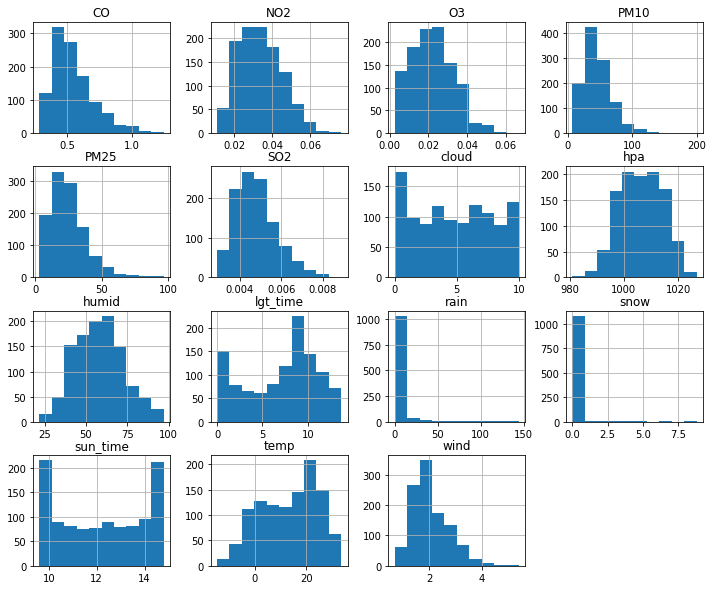

In [8]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

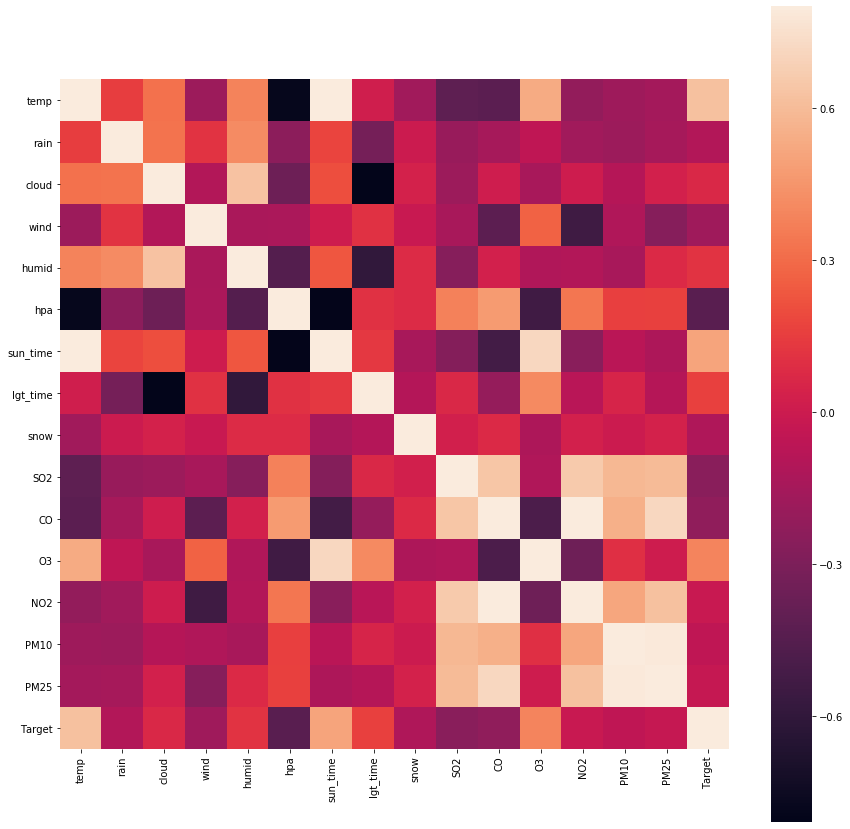

In [9]:
train_data = train_data[num_cols + cat_cols]
train_data['Target'] = target

C_mat = train_data.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

In [10]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 15 columns before encoding categorical features
There are 15 columns after encoding categorical features


In [11]:
cut_line = 732
def split_combined():
    global combined
    train = combined[:cut_line]
    test = combined[cut_line:]

    return train , test 
  
train, test = split_combined()

train.shape

(732, 15)

In [12]:
# 신경망 모델 생성
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

W0717 13:55:13.423256  4772 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0717 13:55:13.438194  4772 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0717 13:55:13.440187  4772 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0717 13:55:13.497036  4772 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 166,913
Trainable params: 166,913
Non-trainable params: 0
_________________________________________________________________


In [13]:
checkpoint_name = 'GS-'+item+grouped_by+'-Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [14]:
NN_model.fit(train, target[:cut_line], epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

W0717 13:55:19.089495  4772 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0717 13:55:19.204160  4772 deprecation_wrapper.py:119] From C:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 585 samples, validate on 147 samples
Epoch 1/500
585/585 [==============================] - 0s 535us/step - loss: 10025.2052 - mean_absolute_error: 10025.2052 - val_loss: 7264.2622 - val_mean_absolute_error: 7264.2622

Epoch 00001: val_loss improved from inf to 7264.26222, saving model to GS-생수date-Weights-001--7264.26222.hdf5
Epoch 2/500
585/585 [==============================] - 0s 75us/step - loss: 4688.0227 - mean_absolute_error: 4688.0227 - val_loss: 2281.5361 - val_mean_absolute_error: 2281.5361

Epoch 00002: val_loss improved from 7264.26222 to 2281.53606, saving model to GS-생수date-Weights-002--2281.53606.hdf5
Epoch 3/500
585/585 [==============================] - 0s 83us/step - loss: 2657.9039 - mean_absolute_error: 2657.9039 - val_loss: 2490.9941 - val_mean_absolute_error: 2490.9941

Epoch 00003: val_loss did not improve from 2281.53606
Epoch 4/500
585/585 [==============================] - 0s 85us/step - loss: 2416.1780 - mean_absolute_error: 2416.1780 - val_loss: 20

585/585 [==============================] - 0s 82us/step - loss: 1382.8029 - mean_absolute_error: 1382.8029 - val_loss: 1265.3132 - val_mean_absolute_error: 1265.3132

Epoch 00032: val_loss did not improve from 1092.88708
Epoch 33/500
585/585 [==============================] - 0s 82us/step - loss: 1389.3469 - mean_absolute_error: 1389.3469 - val_loss: 1650.9636 - val_mean_absolute_error: 1650.9636

Epoch 00033: val_loss did not improve from 1092.88708
Epoch 34/500
585/585 [==============================] - 0s 79us/step - loss: 1386.7969 - mean_absolute_error: 1386.7969 - val_loss: 1213.8283 - val_mean_absolute_error: 1213.8283

Epoch 00034: val_loss did not improve from 1092.88708
Epoch 35/500
585/585 [==============================] - 0s 78us/step - loss: 1380.3380 - mean_absolute_error: 1380.3380 - val_loss: 1215.4581 - val_mean_absolute_error: 1215.4581

Epoch 00035: val_loss did not improve from 1092.88708
Epoch 36/500
585/585 [==============================] - 0s 77us/step - loss: 

585/585 [==============================] - 0s 82us/step - loss: 1456.8057 - mean_absolute_error: 1456.8057 - val_loss: 1080.9969 - val_mean_absolute_error: 1080.9969

Epoch 00067: val_loss improved from 1085.37061 to 1080.99694, saving model to GS-생수date-Weights-067--1080.99694.hdf5
Epoch 68/500
585/585 [==============================] - 0s 77us/step - loss: 1371.4616 - mean_absolute_error: 1371.4616 - val_loss: 1242.9937 - val_mean_absolute_error: 1242.9937

Epoch 00068: val_loss did not improve from 1080.99694
Epoch 69/500
585/585 [==============================] - 0s 78us/step - loss: 1372.5378 - mean_absolute_error: 1372.5378 - val_loss: 1583.4557 - val_mean_absolute_error: 1583.4557

Epoch 00069: val_loss did not improve from 1080.99694
Epoch 70/500
585/585 [==============================] - 0s 78us/step - loss: 1420.9544 - mean_absolute_error: 1420.9544 - val_loss: 1148.0656 - val_mean_absolute_error: 1148.0656

Epoch 00070: val_loss did not improve from 1080.99694
Epoch 71/500
5

585/585 [==============================] - 0s 84us/step - loss: 1395.2343 - mean_absolute_error: 1395.2343 - val_loss: 1465.4640 - val_mean_absolute_error: 1465.4640

Epoch 00101: val_loss did not improve from 1072.41536
Epoch 102/500
585/585 [==============================] - 0s 78us/step - loss: 1363.1281 - mean_absolute_error: 1363.1281 - val_loss: 1403.7459 - val_mean_absolute_error: 1403.7459

Epoch 00102: val_loss did not improve from 1072.41536
Epoch 103/500
585/585 [==============================] - 0s 80us/step - loss: 1347.6498 - mean_absolute_error: 1347.6498 - val_loss: 1349.2745 - val_mean_absolute_error: 1349.2745

Epoch 00103: val_loss did not improve from 1072.41536
Epoch 104/500
585/585 [==============================] - 0s 75us/step - loss: 1362.6300 - mean_absolute_error: 1362.6300 - val_loss: 1167.3322 - val_mean_absolute_error: 1167.3322

Epoch 00104: val_loss did not improve from 1072.41536
Epoch 105/500
585/585 [==============================] - 0s 73us/step - lo

585/585 [==============================] - 0s 94us/step - loss: 1360.4527 - mean_absolute_error: 1360.4527 - val_loss: 1132.8158 - val_mean_absolute_error: 1132.8158

Epoch 00136: val_loss did not improve from 1072.41536
Epoch 137/500
585/585 [==============================] - 0s 77us/step - loss: 1350.3993 - mean_absolute_error: 1350.3993 - val_loss: 1339.0244 - val_mean_absolute_error: 1339.0244

Epoch 00137: val_loss did not improve from 1072.41536
Epoch 138/500
585/585 [==============================] - 0s 84us/step - loss: 1339.8715 - mean_absolute_error: 1339.8715 - val_loss: 1316.4301 - val_mean_absolute_error: 1316.4301

Epoch 00138: val_loss did not improve from 1072.41536
Epoch 139/500
585/585 [==============================] - 0s 85us/step - loss: 1337.3996 - mean_absolute_error: 1337.3996 - val_loss: 1184.7970 - val_mean_absolute_error: 1184.7970

Epoch 00139: val_loss did not improve from 1072.41536
Epoch 140/500
585/585 [==============================] - 0s 77us/step - lo


Epoch 00170: val_loss did not improve from 1063.37571
Epoch 171/500
585/585 [==============================] - 0s 109us/step - loss: 1338.3528 - mean_absolute_error: 1338.3528 - val_loss: 1255.9264 - val_mean_absolute_error: 1255.9264

Epoch 00171: val_loss did not improve from 1063.37571
Epoch 172/500
585/585 [==============================] - 0s 95us/step - loss: 1372.3050 - mean_absolute_error: 1372.3050 - val_loss: 1224.4503 - val_mean_absolute_error: 1224.4503

Epoch 00172: val_loss did not improve from 1063.37571
Epoch 173/500
585/585 [==============================] - 0s 94us/step - loss: 1345.6063 - mean_absolute_error: 1345.6063 - val_loss: 1754.5631 - val_mean_absolute_error: 1754.5631

Epoch 00173: val_loss did not improve from 1063.37571
Epoch 174/500
585/585 [==============================] - 0s 89us/step - loss: 1332.1670 - mean_absolute_error: 1332.1670 - val_loss: 1147.8835 - val_mean_absolute_error: 1147.8835

Epoch 00174: val_loss did not improve from 1063.37571
Epoc


Epoch 00205: val_loss did not improve from 1063.37571
Epoch 206/500
585/585 [==============================] - 0s 136us/step - loss: 1339.3419 - mean_absolute_error: 1339.3419 - val_loss: 1232.5359 - val_mean_absolute_error: 1232.5359

Epoch 00206: val_loss did not improve from 1063.37571
Epoch 207/500
585/585 [==============================] - 0s 113us/step - loss: 1363.4763 - mean_absolute_error: 1363.4763 - val_loss: 1246.8631 - val_mean_absolute_error: 1246.8631

Epoch 00207: val_loss did not improve from 1063.37571
Epoch 208/500
585/585 [==============================] - 0s 119us/step - loss: 1379.5312 - mean_absolute_error: 1379.5312 - val_loss: 1555.5399 - val_mean_absolute_error: 1555.5399

Epoch 00208: val_loss did not improve from 1063.37571
Epoch 209/500
585/585 [==============================] - 0s 118us/step - loss: 1395.6666 - mean_absolute_error: 1395.6666 - val_loss: 1562.7208 - val_mean_absolute_error: 1562.7208

Epoch 00209: val_loss did not improve from 1063.37571
E

585/585 [==============================] - 0s 130us/step - loss: 1403.4776 - mean_absolute_error: 1403.4776 - val_loss: 1442.7020 - val_mean_absolute_error: 1442.7020

Epoch 00240: val_loss did not improve from 1063.37571
Epoch 241/500
585/585 [==============================] - 0s 116us/step - loss: 1327.5048 - mean_absolute_error: 1327.5048 - val_loss: 1840.8207 - val_mean_absolute_error: 1840.8207

Epoch 00241: val_loss did not improve from 1063.37571
Epoch 242/500
585/585 [==============================] - 0s 109us/step - loss: 1365.6499 - mean_absolute_error: 1365.6499 - val_loss: 1415.6303 - val_mean_absolute_error: 1415.6303

Epoch 00242: val_loss did not improve from 1063.37571
Epoch 243/500
585/585 [==============================] - 0s 113us/step - loss: 1437.7538 - mean_absolute_error: 1437.7538 - val_loss: 1664.1617 - val_mean_absolute_error: 1664.1617

Epoch 00243: val_loss did not improve from 1063.37571
Epoch 244/500
585/585 [==============================] - 0s 118us/step


Epoch 00274: val_loss did not improve from 1060.71792
Epoch 275/500
585/585 [==============================] - 0s 125us/step - loss: 1391.4345 - mean_absolute_error: 1391.4345 - val_loss: 1414.2098 - val_mean_absolute_error: 1414.2098

Epoch 00275: val_loss did not improve from 1060.71792
Epoch 276/500
585/585 [==============================] - 0s 130us/step - loss: 1334.9109 - mean_absolute_error: 1334.9109 - val_loss: 1289.0588 - val_mean_absolute_error: 1289.0588

Epoch 00276: val_loss did not improve from 1060.71792
Epoch 277/500
585/585 [==============================] - 0s 130us/step - loss: 1334.6323 - mean_absolute_error: 1334.6323 - val_loss: 1399.4890 - val_mean_absolute_error: 1399.4890

Epoch 00277: val_loss did not improve from 1060.71792
Epoch 278/500
585/585 [==============================] - 0s 115us/step - loss: 1366.3136 - mean_absolute_error: 1366.3136 - val_loss: 1606.4293 - val_mean_absolute_error: 1606.4293

Epoch 00278: val_loss did not improve from 1060.71792
E

585/585 [==============================] - 0s 147us/step - loss: 1335.5810 - mean_absolute_error: 1335.5810 - val_loss: 1586.8589 - val_mean_absolute_error: 1586.8589

Epoch 00309: val_loss did not improve from 1060.71792
Epoch 310/500
585/585 [==============================] - 0s 148us/step - loss: 1390.4841 - mean_absolute_error: 1390.4841 - val_loss: 1195.4543 - val_mean_absolute_error: 1195.4543

Epoch 00310: val_loss did not improve from 1060.71792
Epoch 311/500
585/585 [==============================] - 0s 132us/step - loss: 1329.1618 - mean_absolute_error: 1329.1618 - val_loss: 1491.5462 - val_mean_absolute_error: 1491.5462

Epoch 00311: val_loss did not improve from 1060.71792
Epoch 312/500
585/585 [==============================] - 0s 135us/step - loss: 1337.2386 - mean_absolute_error: 1337.2386 - val_loss: 1244.5403 - val_mean_absolute_error: 1244.5403

Epoch 00312: val_loss did not improve from 1060.71792
Epoch 313/500
585/585 [==============================] - 0s 135us/step

585/585 [==============================] - 0s 146us/step - loss: 1330.5531 - mean_absolute_error: 1330.5531 - val_loss: 1389.4647 - val_mean_absolute_error: 1389.4647

Epoch 00344: val_loss did not improve from 1060.71792
Epoch 345/500
585/585 [==============================] - 0s 136us/step - loss: 1422.4392 - mean_absolute_error: 1422.4392 - val_loss: 1306.0619 - val_mean_absolute_error: 1306.0619

Epoch 00345: val_loss did not improve from 1060.71792
Epoch 346/500
585/585 [==============================] - 0s 135us/step - loss: 1324.0475 - mean_absolute_error: 1324.0475 - val_loss: 1655.2256 - val_mean_absolute_error: 1655.2256

Epoch 00346: val_loss did not improve from 1060.71792
Epoch 347/500
585/585 [==============================] - 0s 142us/step - loss: 1374.0485 - mean_absolute_error: 1374.0485 - val_loss: 1293.2620 - val_mean_absolute_error: 1293.2620

Epoch 00347: val_loss did not improve from 1060.71792
Epoch 348/500
585/585 [==============================] - 0s 145us/step

585/585 [==============================] - 0s 129us/step - loss: 1333.2727 - mean_absolute_error: 1333.2727 - val_loss: 1936.5833 - val_mean_absolute_error: 1936.5833

Epoch 00379: val_loss did not improve from 1060.71792
Epoch 380/500
585/585 [==============================] - 0s 131us/step - loss: 1341.6970 - mean_absolute_error: 1341.6970 - val_loss: 1536.4679 - val_mean_absolute_error: 1536.4679

Epoch 00380: val_loss did not improve from 1060.71792
Epoch 381/500
585/585 [==============================] - 0s 126us/step - loss: 1329.3905 - mean_absolute_error: 1329.3905 - val_loss: 1174.0067 - val_mean_absolute_error: 1174.0067

Epoch 00381: val_loss did not improve from 1060.71792
Epoch 382/500
585/585 [==============================] - 0s 124us/step - loss: 1365.6622 - mean_absolute_error: 1365.6622 - val_loss: 1725.5037 - val_mean_absolute_error: 1725.5037

Epoch 00382: val_loss did not improve from 1060.71792
Epoch 383/500
585/585 [==============================] - 0s 130us/step

585/585 [==============================] - 0s 138us/step - loss: 1317.5790 - mean_absolute_error: 1317.5790 - val_loss: 1294.2348 - val_mean_absolute_error: 1294.2348

Epoch 00414: val_loss did not improve from 1060.71792
Epoch 415/500
585/585 [==============================] - 0s 143us/step - loss: 1353.5875 - mean_absolute_error: 1353.5875 - val_loss: 1325.2683 - val_mean_absolute_error: 1325.2683

Epoch 00415: val_loss did not improve from 1060.71792
Epoch 416/500
585/585 [==============================] - 0s 136us/step - loss: 1338.9444 - mean_absolute_error: 1338.9444 - val_loss: 1367.0821 - val_mean_absolute_error: 1367.0821

Epoch 00416: val_loss did not improve from 1060.71792
Epoch 417/500
585/585 [==============================] - 0s 152us/step - loss: 1333.0697 - mean_absolute_error: 1333.0697 - val_loss: 1607.9473 - val_mean_absolute_error: 1607.9473

Epoch 00417: val_loss did not improve from 1060.71792
Epoch 418/500
585/585 [==============================] - 0s 155us/step

585/585 [==============================] - 0s 159us/step - loss: 1343.0230 - mean_absolute_error: 1343.0230 - val_loss: 1351.7694 - val_mean_absolute_error: 1351.7694

Epoch 00449: val_loss did not improve from 1060.71792
Epoch 450/500
585/585 [==============================] - 0s 149us/step - loss: 1329.6198 - mean_absolute_error: 1329.6198 - val_loss: 1346.0504 - val_mean_absolute_error: 1346.0504

Epoch 00450: val_loss did not improve from 1060.71792
Epoch 451/500
585/585 [==============================] - 0s 143us/step - loss: 1325.3833 - mean_absolute_error: 1325.3833 - val_loss: 1657.8266 - val_mean_absolute_error: 1657.8266

Epoch 00451: val_loss did not improve from 1060.71792
Epoch 452/500
585/585 [==============================] - 0s 181us/step - loss: 1351.7411 - mean_absolute_error: 1351.7411 - val_loss: 1431.4110 - val_mean_absolute_error: 1431.4110

Epoch 00452: val_loss did not improve from 1060.71792
Epoch 453/500
585/585 [==============================] - 0s 169us/step

585/585 [==============================] - 0s 126us/step - loss: 1371.2273 - mean_absolute_error: 1371.2273 - val_loss: 1312.4151 - val_mean_absolute_error: 1312.4151

Epoch 00484: val_loss did not improve from 1060.71792
Epoch 485/500
585/585 [==============================] - 0s 135us/step - loss: 1292.6658 - mean_absolute_error: 1292.6658 - val_loss: 1433.4563 - val_mean_absolute_error: 1433.4563

Epoch 00485: val_loss did not improve from 1060.71792
Epoch 486/500
585/585 [==============================] - 0s 130us/step - loss: 1284.0451 - mean_absolute_error: 1284.0451 - val_loss: 1634.1099 - val_mean_absolute_error: 1634.1099

Epoch 00486: val_loss did not improve from 1060.71792
Epoch 487/500
585/585 [==============================] - 0s 137us/step - loss: 1295.6106 - mean_absolute_error: 1295.6106 - val_loss: 1369.3289 - val_mean_absolute_error: 1369.3289

Epoch 00487: val_loss did not improve from 1060.71792
Epoch 488/500
585/585 [==============================] - 0s 134us/step

In [15]:
# Load wights file of the best model :
wights_file = 'GS-생수date-Weights-263--1060.71792.hdf5' # choose the best checkpoint 
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

In [16]:
train_X, val_X, train_y, val_y = train_test_split(train, target[:cut_line], test_size = 0.25, random_state = 14)

In [17]:
model = RandomForestRegressor()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
RFpredicted = model.predict(val_X)
MAE = mean_absolute_error(val_y , RFpredicted)
print('Random forest validation MAE = ', MAE)
# print('훈련세트점수 : {:.2f}'.format(model.score(train_X, train_y)))
# print('검증세트점수 : {:.2f}'.format(model.score(val_X, val_y)))

Random forest validation MAE =  1476.6387978142077


In [18]:
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)
# print('훈련세트점수 : {:.2f}'.format(XGBModel.score(train_X, train_y)))
# print('검증세트점수 : {:.2f}'.format(XGBModel.score(val_X, val_y)))

[13:56:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBoost validation MAE =  1236.4316059383539


In [19]:
combined = gs_day_w.loc[:,'temp':'PM25']
target = gs_day_w.loc[:,'qty']
RFpredicted = model.predict(combined)
XGBpredictions = XGBModel.predict(combined)
predictions = NN_model.predict(combined)

result_df = pd.DataFrame()
result_df['date'] = gs_day_w['date']
result_df['qty'] = gs_day_w.loc[:,'qty']
print("keras 신경망 predictions",predictions.shape)
result_df['keras_qty'] = predictions
print("randomforest 예상",RFpredicted.shape)
result_df['rf_qty'] = RFpredicted
print("XGBpredictions",XGBpredictions.shape)
result_df['xgb_qty'] = XGBpredictions

keras 신경망 predictions (1096, 1)
randomforest 예상 (1096,)
XGBpredictions (1096,)


In [20]:
df_graph = result_df.loc[:,['date','keras_qty','rf_qty','xgb_qty','qty']]
df_graph['date'] = pd.to_datetime(df_graph['date'])

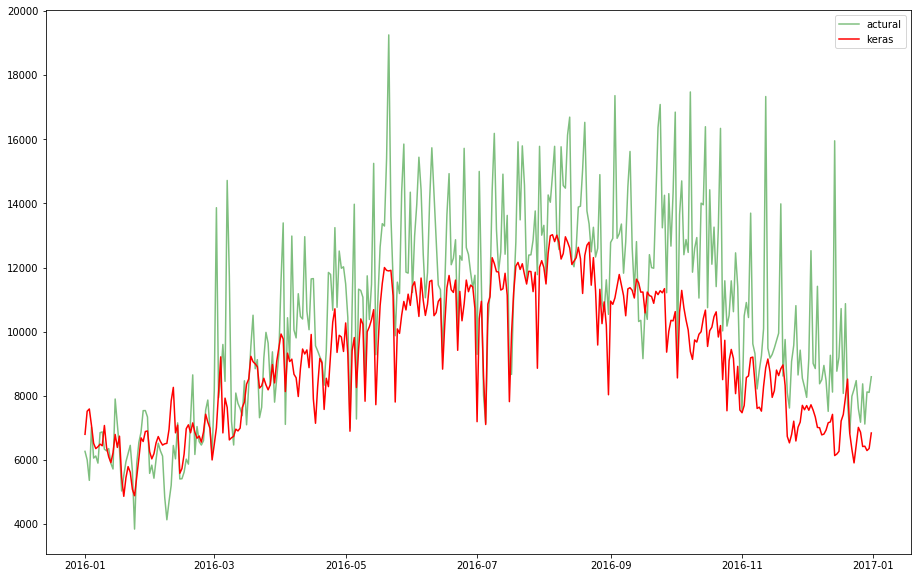

In [21]:
df_graph = result_df.loc[result_df.date.between('2016-01-01','2016-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green', alpha=0.5)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

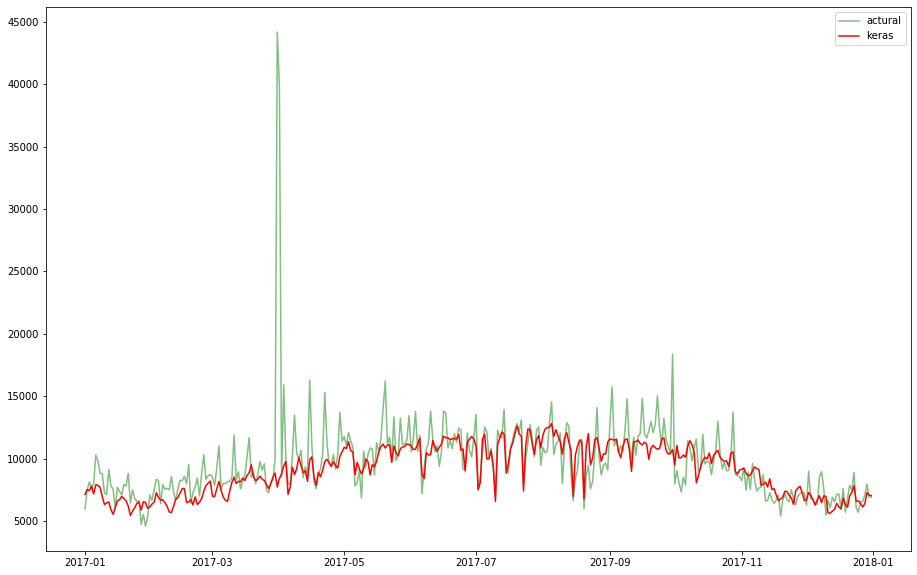

In [22]:
df_graph = result_df.loc[result_df.date.between('2017-01-01','2017-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green', alpha=0.5)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

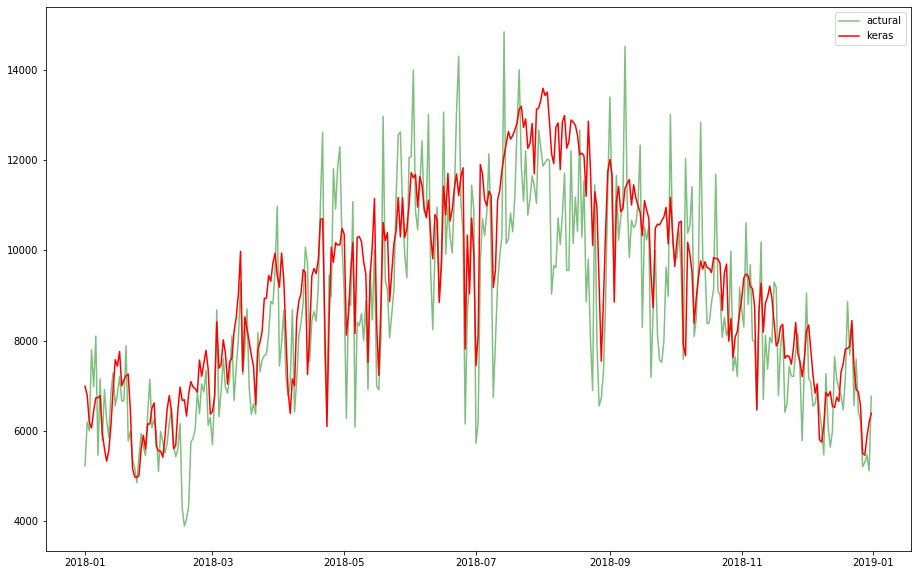

In [23]:
df_graph = result_df.loc[result_df.date.between('2018-01-01','2018-12-31')]
plt.figure(figsize=(15.5, 10))
plt.plot(df_graph.date,df_graph.qty, ls='-', label='actural', color='green', alpha=0.5)
plt.plot(df_graph.date,df_graph.keras_qty, ls='-', label='keras', color='r')
# plt.plot(df_graph.date,df_graph.rf_qty, ls='--', label='rf', color='cyan')
# plt.plot(df_graph.date,df_graph.xgb_qty, ls='--', label='xgb', color='green')
plt.legend()
plt.show()

In [24]:
path = 'D:/project/contest/data/result/'
result_df.to_csv(path+item+'_'+grouped_by+'_predict.csv', encoding='utf-8', index=False)

W0717 13:56:52.855019  4772 legend.py:1282] No handles with labels found to put in legend.


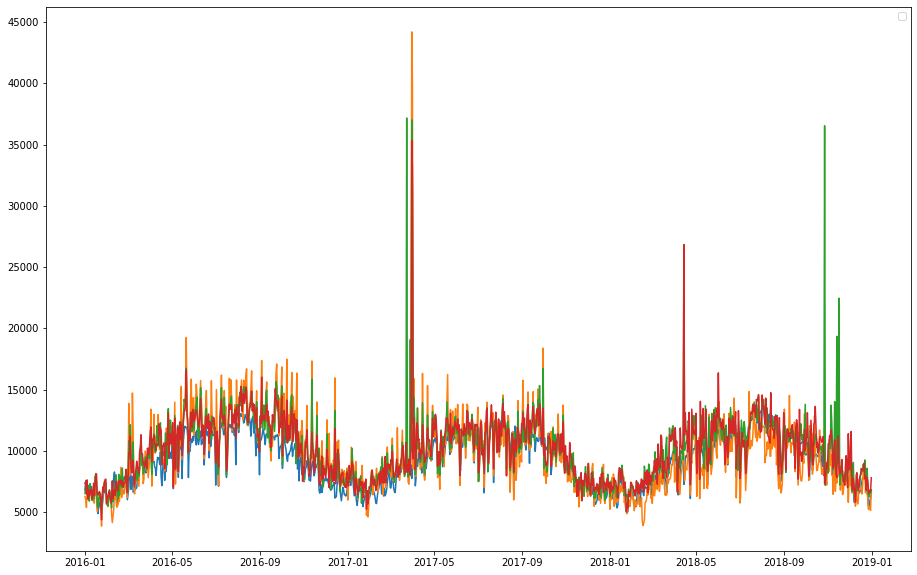

In [25]:
plt.figure(figsize=(15.5, 10))
plt.plot(result_df.date,result_df.keras_qty)
plt.plot(result_df.date,result_df.qty)
plt.plot(result_df.date,result_df.rf_qty)
plt.plot(result_df.date,result_df.xgb_qty)
plt.legend()
plt.show()

In [65]:
result_df.head(2)

,date,qty,keras_qty,rf_qty,xgb_qty
0,2016-01-01,15929,8426.595703,13399.5,11620.145508
1,2016-01-02,13086,9169.041016,10552.9,10274.932617


In [26]:
result_df['keras_accu'] = abs( (result_df.keras_qty / result_df.qty) )
result_df['rf_accu'] = abs( (result_df.rf_qty / result_df.qty) )
result_df['xgb_accu'] = abs( (result_df.xgb_qty / result_df.qty) )
result_df.tail()

,date,qty,keras_qty,rf_qty,xgb_qty,keras_accu,rf_accu,xgb_accu
1091,2018-12-27,5210,5501.487305,6426.7,6865.682129,1.055948,1.233532,1.317789
1092,2018-12-28,5303,5462.082520,6247.7,6535.402832,1.029999,1.178144,1.232397
1093,2018-12-29,5471,5876.991211,6778.3,6722.399414,1.074208,1.238951,1.228733
1094,2018-12-30,5122,6197.023438,6536.4,6701.834961,1.209884,1.276142,1.308441
1095,2018-12-31,6767,6393.269531,6815.7,7797.836914,0.944772,1.007197,1.152333


In [27]:
result_df['qtyMinusMean'] = (result_df.qty-np.mean(result_df.qty) )
result_df['qtyMinusMeanSquared'] = (result_df.qty-np.mean(result_df.qty) )**2

result_df['kerasMiunsMeanSquared'] = (result_df.keras_qty-np.mean(result_df.qty))**2
result_df['rfMiunsMeanSquared'] = (result_df.rf_qty-np.mean(result_df.qty))**2
result_df['xgbMiunsMeanSquared'] = (result_df.xgb_qty-np.mean(result_df.qty))**2

print('kreas R-sq',(sum(result_df['kerasMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('rf R-sq',(sum(result_df['rfMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))
print('xgb R-sq',(sum(result_df['xgbMiunsMeanSquared']) / sum(result_df['qtyMinusMeanSquared'])))